In [1]:
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/students-performance-dataset")

print("Path to dataset files:", path)

import pandas as pd
df = pd.read_csv( path + "/Student_performance_data _.csv" )

df.head()

/home/lucas/miniconda3/envs/torch_gpu2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/lucas/.cache/kagglehub/datasets/rabieelkharoua/students-performance-dataset/versions/2


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [2]:
# Drop StudentID column
data = df.drop( columns = ['StudentID', 'GPA'] )

# Organize columns
numerical_columns = ['Age', 'StudyTimeWeekly', 'Absences' ]
categorical_columns = ['Ethnicity', 'ParentalEducation', 'Extracurricular', 'Gender', 'Tutoring', 'ParentalSupport', 'Sports', 'Music', 'Volunteering']
target_column = 'GradeClass'

In [3]:
# One-hot encode categorical columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Scale numerical columns
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [4]:
data = data.astype('float32')
data.head()

,Age,StudyTimeWeekly,Absences,GradeClass,Ethnicity_1,Ethnicity_2,Ethnicity_3,ParentalEducation_1,ParentalEducation_2,ParentalEducation_3,...,Extracurricular_1,Gender_1,Tutoring_1,ParentalSupport_1,ParentalSupport_2,ParentalSupport_3,ParentalSupport_4,Sports_1,Music_1,Volunteering_1
0,0.472919,1.780336,-0.890822,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.362944,0.997376,-1.717694,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.307132,-0.984045,1.353542,4.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.472919,0.045445,-0.063951,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.472919,-0.902311,0.290422,4.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
train, test = train_test_split( data, test_size = 0.2, random_state = 42 )
len(train), len(test)

(1913, 479)

In [6]:
X_train = train.drop( columns = [target_column] )
y_train = train[target_column]

X_test = test.drop( columns = [target_column] )
y_test = test[target_column]

In [7]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter
import torch
import torch.nn as nn
import torch.functional as F

class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

# Create Balanced Sampler
class_counts = Counter( y_train )
num_classes = len( class_counts )
total_samples = len( X_train )
class_weights = { cls: total_samples/( num_classes * count ) for cls, count in class_counts.items() }
sample_weights = [ class_weights[label.item()] for label in y_train.values ]
sample_weights = torch.tensor( sample_weights, dtype = torch.float )
sampler = WeightedRandomSampler( weights = sample_weights, 
                                 num_samples = len( sample_weights ), 
                                 replacement = True )

# Create datasets
X_train = X_train.values
y_train = y_train.values
train_dataset = CustomDataset( X_train, y_train )

X_test = X_test.values
y_test = y_test.values
test_dataset = CustomDataset( X_test, y_test )

# Create dataloaders
train_loader = DataLoader( train_dataset, batch_size = 32, sampler = sampler )
test_loader = DataLoader( test_dataset, batch_size = 32 )

In [ ]:
class VectorQuantizer(nn.Module):
    
    def __init__(self, input_size: int, num_embeddings: int, embedding_dim: int, num_codebooks: int):
        
        super(VectorQuantizer, self).__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.num_codebooks = num_codebooks

        # Codebook shape: [num_codebooks, num_embeddings, embedding_dim]
        self.codebook = nn.Parameter( torch.randn( num_codebooks, num_embeddings, embedding_dim ) )
        nn.init.normal_( self.codebook, mean = 0.0, std = 0.5 )

        self.commitment_cost = 0.25
        self.sparsity_weight = 0.1

        # Transform input into a space of size num_codebooks * embedding_dim
        self.transform1 = nn.Linear( input_size, num_codebooks * embedding_dim )
        self.layernorm = nn.LayerNorm( num_codebooks * embedding_dim )
        self.transform2 = nn.Linear( embedding_dim, embedding_dim )
        
    def forward(self, inputs: torch.Tensor):
        """
        Input:
          inputs: shape [B, input_size]

        Output:
          quantized: shape [B, num_codebooks, embedding_dim]
          indices: shape [B, num_codebooks]
          codebook_loss: scalar
        """

        # Transform input to [B, embedding_dim]
        z = self.transform1( inputs )  # [B, num_codebooks*embedding_dim]
        z = self.layernorm( z )

        # Reshape z to [B, num_codebooks, embedding_dim]
        B = z.size(0)
        z = z.view( B, self.num_codebooks, self.embedding_dim )

        # Compute distances to codebook entries
        # z: [B, num_codebooks, embedding_dim]
        # codebook: [num_codebooks, num_embeddings, embedding_dim]

        # Expand for broadcasting:
        # z_expanded: [B, num_codebooks, 1, embedding_dim]
        # codebook_expanded: [1, num_codebooks, num_embeddings, embedding_dim]
        z_expanded = z.unsqueeze(2)
        codebook_expanded = self.codebook.unsqueeze(0)

        # Compute squared L2 distance: (z - c)^2
        # distances: [B, num_codebooks, num_embeddings]
        distances = ( z_expanded - codebook_expanded ).pow(2).sum( dim = -1 )

        # Find the closest codebook entry for each codebook
        # indices: [B, num_codebooks]
        with torch.no_grad():
            indices = torch.argmin( distances, dim = -1 )

        # Gather the quantized vectors from the codebook
        # We'll do this per codebook dimension
        # codebook: [C, N, D]
        # indices: [B, C]  where each element is in range [0, N-1]
        B = indices.size(0)
        C = self.num_codebooks

        # Create an index for the codebook dimension
        # c_idx: [B, C], where each row is [0, 1, 2, ..., C-1]
        c_idx = torch.arange( C, device = indices.device ).unsqueeze(0).expand( B, -1 )

        # Now use advanced indexing:
        # codebook[c_idx, indices, :] will gather a [B, C, D] tensor
        quantized = self.codebook[c_idx, indices, :] # Fro this point, the model is not differentiable

        # Skip gradient computation for the codebook
        quantized = z + ( quantized - z ) # 5 + ( 7 - 5 ) = 7

        # Codebook loss:
        # ||sg[z] - e||_2^2 + beta * ||z - sg[e]||_2^2
        e = quantized
        z_detach = z.detach()
        e_detach = e.detach()
        codebook_loss = ( z_detach - e ).pow(2).mean() + self.commitment_cost * ( z - e_detach ).pow(2).mean()

        # Add L1 sparsity penalty on the codebook
        # This encourages many codebook entries to be close to zero.
        # sparsity_loss = self.sparsity_weight * torch.abs( self.codebook ).mean()

        # Diversity loss (no loop):
        # one_hot_indices: [B, C, N]
        one_hot_indices = F.one_hot( indices, num_classes = self.num_embeddings ).float()
        ## counts: [C, N] after summation over batch
        counts = one_hot_indices.sum( dim = 0 ) # sum over B
        ## p: [C, N]
        p = counts / counts.sum( dim = 1, keepdim = True )
        ## KL divergence to uniform:
        ## KL(p||u) = sum_j p_j * log(p_j * N)
        epsilon = 1e-9
        kl = p * ( p.add( epsilon ).log() + torch.log( torch.tensor( self.num_embeddings, device = p.device, dtype = p.dtype ) ) )
        kl_sum = kl.sum( dim = 1 )  # [C]
        diversity_loss = kl_sum.mean()

        # Apply transform2 to each codebook dimension
        # We have [B, num_codebooks, embedding_dim], transform2 is [embedding_dim -> embedding_dim]
        # Reshape to [B*num_codebooks, embedding_dim], apply transform, reshape back
        B, NC, D = quantized.shape
        quantized = quantized.reshape( B*NC, D )
        quantized = F.gelu( self.transform2( quantized ) )
        quantized = quantized.reshape( B, NC, D )

        return quantized, indices, codebook_loss + diversity_loss

In [9]:
class SimpleModel(nn.Module):
    
    def __init__(self, embedding_dim, num_variables, num_codes):
        super(SimpleModel, self).__init__()
        
        self.num_variables = num_variables
        input_size = X_train.shape[1]

        if num_variables != 0:
            self.variables = VectorQuantizer( input_size, num_codes, embedding_dim, num_variables )
            self.weight_variable = nn.Parameter( torch.randn( num_variables ) )
            self.layer = nn.Linear( input_size, embedding_dim )
            self.norm = nn.LayerNorm( embedding_dim )
            self.model = nn.Sequential(

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim//2 ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim//2, len( class_counts ) )
            )
        else:

            self.model = nn.Sequential(

                nn.Linear( input_size, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim, embedding_dim//2 ),
                nn.ReLU(),
                nn.Dropout( p = 0.3 ),

                nn.Linear( embedding_dim//2, len( class_counts ) )
            )
                
    def forward(self, x):
        
        if self.num_variables != 0:
            # Create N synthetic variables
            quantized, indices, codebook_loss = self.variables( x )
            w = F.softmax( self.weight_variable, dim = 0 )
            # w = F.sigmoid( self.weight_variable )
            quantized = ( quantized * w[None, :, None] ).sum( dim = 1 )

            # Process the original variables by non-linear layer
            hidden = F.gelu( self.layer( x ) )

            # Concatenate the synthetic variables with the original variables
            all_variables = self.norm( hidden + quantized )
        
        else:
            all_variables = x
            codebook_loss = 0.0
            indices = torch.zeros( x.size(0) )

        # Predict the target variable
        prediction = self.model( all_variables )
        prediction = F.log_softmax( prediction, dim = -1 )

        return prediction, codebook_loss, indices

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_plot_live(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=10):
    train_precision, train_recall, train_accuracy = [], [], []
    test_precision, test_recall, test_accuracy = [], [], []
    train_losses, test_losses = [], []

    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        all_preds = []
        all_targets = []
        total_loss = 0
        total_samples = 0
        all_indices = []

        for batch in train_dataloader:
            inputs = batch[0].to(device)
            targets = batch[1].long().to(device)  # Targets for classification are long

            optimizer.zero_grad()
            predictions, codebook_loss, indices = model(inputs)

            # predictions: [B, num_classes]
            # targets: [B]
            loss = criterion(predictions, targets) + codebook_loss
            loss.backward()
            # optimizer.step(zero_grad=True)
            optimizer.first_step(zero_grad=True)

            # Second forward-backward step
            predictions, codebook_loss, indices = model(inputs)
            loss = criterion(predictions, targets) + codebook_loss
            loss.backward()
            optimizer.second_step(zero_grad=True)

            batch_size = len(targets)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Convert predictions to class indices
            preds_classes = torch.argmax(predictions, dim=1).cpu().numpy()
            targets_cpu = targets.cpu().numpy()
            all_preds.extend(preds_classes)
            all_targets.extend(targets_cpu)
            all_indices.extend(indices.cpu().numpy().ravel())

        # Compute train classification metrics
        train_precision.append(precision_score(all_targets, all_preds, average="weighted", zero_division=0))
        train_recall.append(recall_score(all_targets, all_preds, average="weighted", zero_division=0))
        train_accuracy.append(accuracy_score(all_targets, all_preds))
        train_losses.append(total_loss / total_samples if total_samples > 0 else 0.0)

        # Testing phase
        model.eval()
        all_preds = []
        all_targets = []
        test_total_loss = 0
        test_total_samples = 0
        with torch.no_grad():
            for batch in test_dataloader:
                inputs = batch[0].to(device)
                targets = batch[1].long().to(device)

                predictions, codebook_loss, _ = model(inputs)
                loss = criterion(predictions, targets)

                batch_size = len(targets)
                test_total_loss += loss.item() * batch_size
                test_total_samples += batch_size

                preds_classes = torch.argmax(predictions, dim=1).cpu().numpy()
                targets_cpu = targets.cpu().numpy()
                all_preds.extend(preds_classes)
                all_targets.extend(targets_cpu)

        # Compute test classification metrics
        test_precision.append(precision_score(all_targets, all_preds, average="weighted", zero_division=0))
        test_recall.append(recall_score(all_targets, all_preds, average="weighted", zero_division=0))
        test_accuracy.append(accuracy_score(all_targets, all_preds))
        test_losses.append(test_total_loss / test_total_samples if test_total_samples > 0 else 0.0)

        # Gather all weights for the histogram
        weights = []
        for param in model.parameters():
            weights.append(param.detach().cpu().numpy().ravel())
        all_weights = np.concatenate(weights, axis=0)

        if epoch % 10 == 0:
            # Live update the chart
            clear_output(wait=True)
            epochs_range = range(1, len(train_losses) + 1)

            plt.figure(figsize=(18, 5))

            # Subplot 1: Precision, Recall, Accuracy
            plt.subplot(1, 5, 1)
            plt.plot(epochs_range, train_precision, label="Train Precision", marker="o")
            plt.plot(epochs_range, test_precision, label="Test Precision", marker="o")
            plt.plot(epochs_range, train_recall, label="Train Recall", marker="o")
            plt.plot(epochs_range, test_recall, label="Test Recall", marker="o")
            plt.plot(epochs_range, train_accuracy, label="Train Accuracy", marker="o")
            plt.plot(epochs_range, test_accuracy, label="Test Accuracy", marker="o")
            plt.title("Classification Metrics")
            plt.xlabel("Epochs")
            plt.ylabel("Score")
            plt.legend()
            plt.grid()

            # Subplot 2: Loss
            plt.subplot(1, 5, 2)
            plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
            plt.plot(epochs_range, test_losses, label="Test Loss", marker="o")
            plt.title("Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()

            # Subplot 3
            try:
                weights_code = F.softmax( model.weight_variable, dim = 0 ).detach().cpu().numpy()
                # weights_code = model.weight_variable.detach().cpu().numpy()
            except:
                weights_code = [0,0,0,0,0,0,0,0]
            # plot the distribution of the codebook weights
            plt.subplot(1, 5, 3)
            plt.bar(range(len(weights_code)), weights_code, color='b')
            plt.title("Codebook Weights")
            plt.xlabel("Codebook Index")
            plt.ylabel("Weight Value")
            plt.grid(True)
            
            # Subplot 4: Weights distribution
            q1 = np.percentile(all_weights, 25)
            q3 = np.percentile(all_weights, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            filtered_weights = all_weights[(all_weights >= lower_bound) & (all_weights <= upper_bound)]

            plt.subplot(1, 5, 5)
            plt.hist(filtered_weights, bins=100, alpha=0.7, color='g')
            plt.title("Weight Distribution")
            plt.xlabel("Weight Value")
            plt.ylabel("Count")
            plt.grid(True)

            # Subplot 5: Codebook indices distribution
            plt.subplot(1, 5, 4)
            plt.hist(all_indices, bins=100, alpha=0.7)
            plt.title("Codebook Indices Distribution")
            plt.xlabel("Index")
            plt.ylabel("Count")
            plt.grid(True)

            plt.tight_layout()
            display(plt.gcf())
            plt.close()

    return model

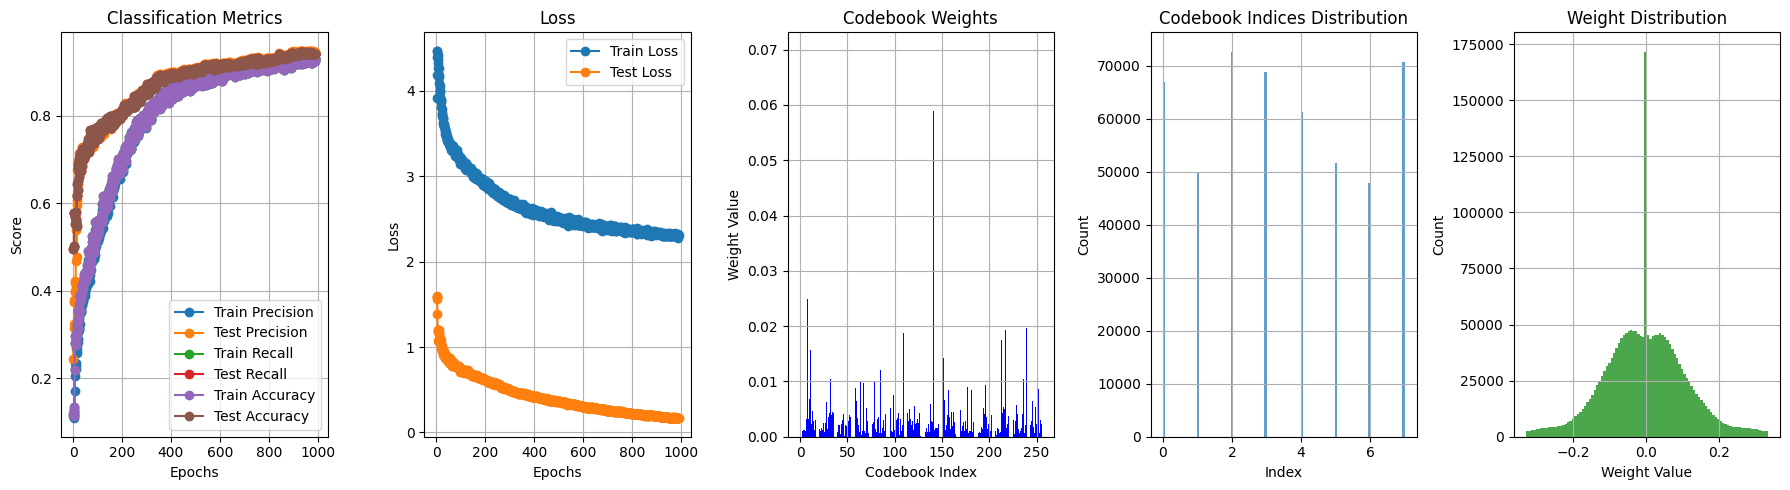

Training: 100%|██████████| 1000/1000 [11:32<00:00,  1.44it/s]


In [ ]:
from adopt import ADOPT
from torch.optim import AdamW
from optimizers_torch import SAM

model = SimpleModel( 256, 256, 8 ).to(device)
optimizer = SAM( model.parameters(), base_optimizer = AdamW, lr = 1e-4, weight_decay = 1e-4, rho = 0.55 )
criterion = nn.CrossEntropyLoss()
trained_model = train_and_plot_live( model, train_loader, test_loader, optimizer, criterion, epochs = 1000 )

In [16]:
from sklearn.metrics import classification_report

trained_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        targets = batch[1].long().to(device)

        predictions, _, _ = trained_model(inputs)
        preds_classes = torch.argmax(predictions, dim=1).cpu().numpy()
        targets_cpu = targets.cpu().numpy()
        all_preds.extend(preds_classes)
        all_targets.extend(targets_cpu)

print( classification_report( all_targets, all_preds ) )

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        22
           1       0.84      0.96      0.90        49
           2       0.97      0.89      0.93        85
           3       0.92      0.97      0.94        86
           4       0.97      0.99      0.98       237

    accuracy                           0.95       479
   macro avg       0.94      0.87      0.89       479
weighted avg       0.95      0.95      0.94       479



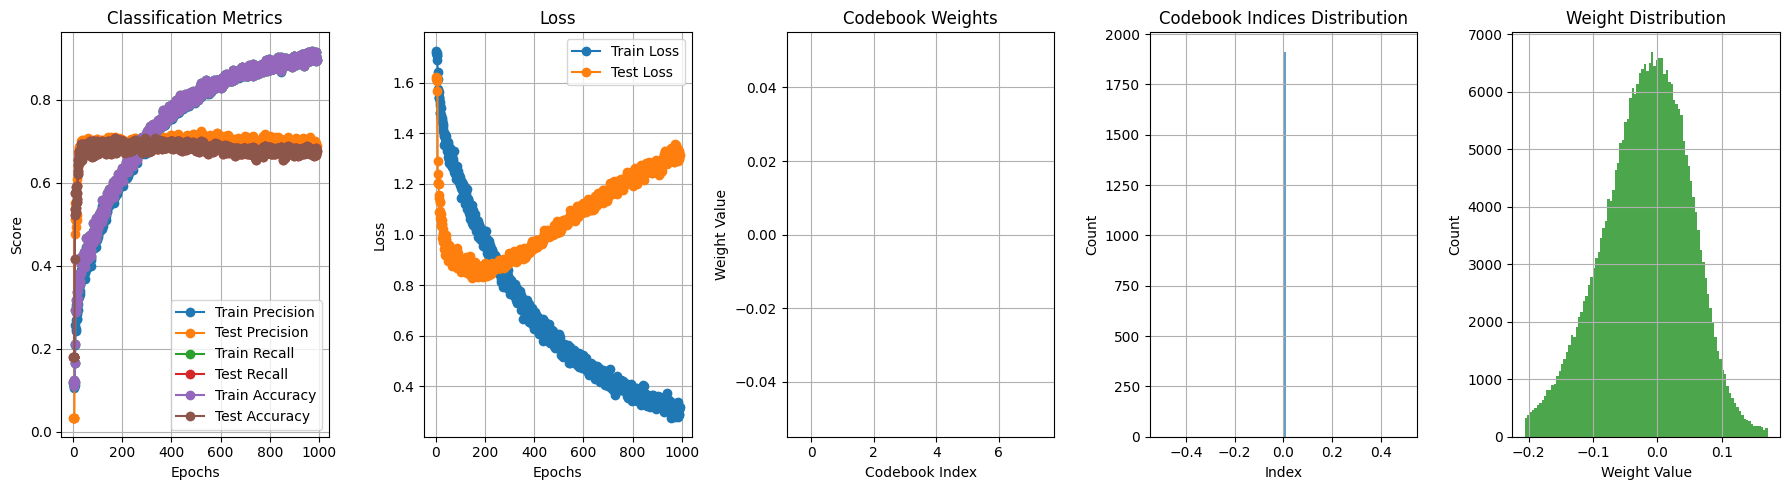

Training: 100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]


In [19]:
model = SimpleModel( 256, 0, 0 ).to(device)
optimizer = SAM( model.parameters(), base_optimizer = AdamW, lr = 1e-4, weight_decay = 1e-4, rho = 0.55 )
criterion = nn.CrossEntropyLoss()
trained_model_1 = train_and_plot_live( model, train_loader, test_loader, optimizer, criterion, epochs = 1000 )

In [20]:
trained_model_1.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        targets = batch[1].long().to(device)

        predictions, _, _ = trained_model_1(inputs)
        preds_classes = torch.argmax(predictions, dim=1).cpu().numpy()
        targets_cpu = targets.cpu().numpy()
        all_preds.extend(preds_classes)
        all_targets.extend(targets_cpu)

print( classification_report( all_targets, all_preds ) )

              precision    recall  f1-score   support

           0       0.75      0.27      0.40        22
           1       0.45      0.63      0.53        49
           2       0.51      0.48      0.50        85
           3       0.43      0.44      0.44        86
           4       0.88      0.86      0.87       237

    accuracy                           0.67       479
   macro avg       0.60      0.54      0.55       479
weighted avg       0.68      0.67      0.67       479

